In [15]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

In [2]:
train_path = "data/train.csv"
test_path = "data/test.csv"
submit_path = "data/submit.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_submit = pd.read_csv(submit_path)

df_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [3]:
df_test["label"] = df_submit["label"]

In [4]:
# Filter 
def filter(texts):
    clean_data_array = []
    i = 0
    for text in texts:
        text = str(text)
        text.lower()
        filteredText = re.sub('[^A-Za-z]+', ' ', text)
        words = nltk.word_tokenize(filteredText)
        stopwords = nltk.corpus.stopwords.words("english")
        cleaned = [word for word in words if word not in stopwords]
        cleaned = [word.lower() for word in words if (word not in stopwords) and len(word) > 2]
        clean_data_array.append(cleaned)

    return clean_data_array

In [5]:
df_train["text"] = filter(df_train["text"])
df_test["text"] = filter(df_test["text"])

In [6]:
df_train["author"].fillna('Unknown', inplace=True)
df_test["author"].fillna('Unknown', inplace=True)

In [7]:
print(len(df_train["text"]))

20800


In [8]:
# Create dataframe from 2 vectors and filter
df_train = pd.DataFrame({'author': df_train["author"], 'text': df_train["text"], 'label': df_train["label"]})
df_test = pd.DataFrame({'author': df_test["author"], 'text': df_test["text"], 'label': df_test["label"]})


In [9]:
min_length, max_length = 100, 1000

df_train_shorter = df_train[df_train['text'].str.len() > min_length]
df_train_shorter = df_train_shorter[df_train_shorter['text'].str.len() < max_length]

df_test_shorter = df_test[df_test['text'].str.len() > min_length]
df_test_shorter = df_test_shorter[df_test_shorter['text'].str.len() < max_length]

len(df_train_shorter["author"]), len(df_test_shorter["author"])

(16305, 4126)

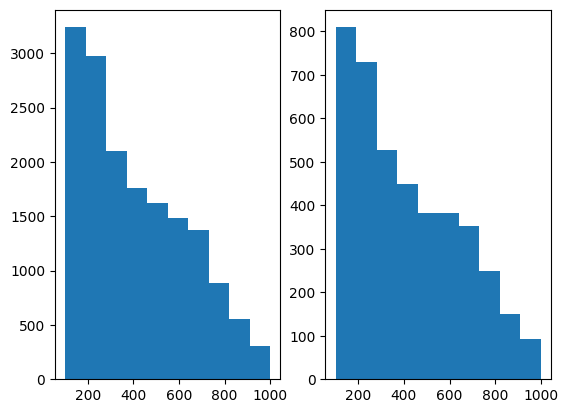

In [21]:
fig, ax = plt.subplots(2)

plt.subplot(121)
plt.hist(df_train_shorter["text"].str.len())

plt.subplot(122)
plt.hist(df_test_shorter["text"].str.len())

plt.show()

In [10]:
frames = [df_train_shorter, df_test_shorter]
df = pd.concat(frames, ignore_index=True)

,author,text,label
0,Darrell Lucus,"[house, dem, aide, didn, even, see, comey, let...",1
1,Daniel J. Flynn,"[ever, get, feeling, life, circles, roundabout...",0
2,Consortiumnews.com,"[why, truth, might, get, you, fired, october, ...",1
3,Jessica Purkiss,"[videos, civilians, killed, single, airstrike,...",1
4,Daniel Nussbaum,"[trying, times, jackie, mason, voice, reason, ...",0
...,...,...,...
20426,Pam Key,"[pres, trump, tapes, exist, conversations, com...",1
20427,Sheryl Gay Stolberg,"[washington, gov, john, kasich, ohio, tuesday,...",1
20428,Mike McPhate,"[good, morning, want, get, california, today, ...",0
20429,Unknown,"[previous, next, marines, deployed, russian, b...",1


In [11]:
# Create vocabulary
def create_vocab(df, label, filename):
    vocabulary, index   = {}, 1
    vocabulary["<pad>"] = 0 # padding token

    if label == "author":
        for author in df[label]:
            if author not in vocabulary:
                vocabulary[author] = index
                index += 1
    else:
        for tokens in df[label]:
            for token in tokens:
                if token not in vocabulary:
                    vocabulary[token] = index
                    index += 1
        
    with open(filename, mode='w') as file:
        json.dump(vocabulary, file, indent=4)
    
    return vocabulary

# Create inverse vocabulary
def create_inverse_vocab(vocab, filename):
    inverse_vocab = {index: token for token, index in vocab.items()}

    with open(filename, mode='w') as file:
        json.dump(inverse_vocab, file, indent=4)

    return inverse_vocab

In [12]:
text_vocab = create_vocab(df, "text", "./data/text_vocab.json")
author_vocab = create_vocab(df, "author", "./data/author_vocab.json")

inverse_text_vocab = create_inverse_vocab(text_vocab, "./data/inverse_text_vocab.json")
inverse_author_vocab = create_inverse_vocab(author_vocab, "./data/inverse_author_vocab.json")

In [13]:
df_train_shorter.to_csv("train_data.csv", index=False)

In [14]:
df_test_shorter.to_csv("test_data.csv", index=False)